In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import pywt
from scipy import signal
from scipy.signal import firwin, lfilter, iirnotch
from statistics import median
import math
from google.colab import files
#!pip install biosignalsnotebooks
import biosignalsnotebooks as bsnb

# Scientific packages
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch,butter, lfilter

In [52]:
VCC = 3.3
n = 10

Fs = 1000
uploaded = files.upload()

# Leer el archivo
file_name = "Jo_Flexion1.txt"
datos = np.loadtxt(file_name)
print(datos)
datos = datos[:, 5]
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)

frec_muestreo = Fs
tiempo = np.arange(len(datos)) / frec_muestreo
print(len(datos))

Saving Jo_Flexion1.txt to Jo_Flexion1 (8).txt
[[  0.   0.   0. ... 316.  38.   1.]
 [  1.   0.   0. ... 524.  38.   1.]
 [  2.   0.   0. ... 736.  38.   1.]
 ...
 [  9.   0.   0. ...   0.  38.   1.]
 [ 10.   0.   0. ...   0.  38.   1.]
 [ 11.   0.   0. ...   0.  38.   1.]]
[494. 499. 500. ... 528. 523. 517.]
13500


In [64]:
# Aplicar el filtro a la señal EMG


fs = 1000  # frec de muestreo
fc = 200   # frac de corte
order = 5
b, a = butter(order, fc / (fs / 2), btype='low')
filtered_signal = lfilter(b, a, datos)

burst_begin, burst_end = bsnb.detect_emg_activations(filtered_signal, Fs, smooth_level=20, threshold_level=10,
                                                     time_units=True, plot_result=True)[:2]
bursts_time = burst_end - burst_begin

# Parameter extraction
max_time = max(bursts_time)
min_time = min(bursts_time)
avg_time = average(bursts_time)
std_time = std(bursts_time)

time_param_dict = {"Maximum time": max_time, "Minimum time": min_time,
                   "Average time": avg_time, "Standard Deviation time": std_time}
print(time_param_dict)

{'Maximum time': 13.099970368175418, 'Minimum time': 13.099970368175418, 'Average time': 13.099970368175418, 'Standard Deviation time': 0.0}


In [58]:
# Maximum
max_sample_value = max(filtered_signal)

# Minimum
min_sample_value = min(filtered_signal)

# Average and Standard Deviation
avg_sample_value = average(filtered_signal)
std_sample_value = std(filtered_signal)

time_param_dict = {"Maximum EMG": max_sample_value, "Minimum EMG": min_sample_value,
                   "Average EMG": avg_sample_value, "Standard Deviation EMG": std_sample_value}
print(time_param_dict)

{'Maximum EMG': 0.33927615659936916, 'Minimum EMG': -0.7526895780244606, 'Average EMG': -0.00981739507679961, 'Standard Deviation EMG': 0.07729475074507437}


In [56]:
# Root Mean Square
rms = sqrt(sum(filtered_signal * filtered_signal) / len(filtered_signal))

nperseg = 256
noverlap = 128 %  50%

f, Pxx = welch(filtered_signal, fs=Fs, window='hamming', nperseg=nperseg, noverlap=noverlap,nfft=int(256.))

area = cumtrapz(np.abs(filtered_signal), tiempo, initial=0)[-1]
# Total Power and Median Frequency (Frequency that divides the spectrum into two regions with equal power)
area_freq = cumtrapz(Pxx, f, initial=0)
total_power = area_freq[-1]
median_freq = f[where(area_freq >= total_power / 2)[0][0]]
f_max = f[argmax(Pxx)]
bsnb.emg_parameters(filtered_signal, Fs, raw_to_mv=False)



{'Number of Muscular Activations': 1,
 'Maximum Muscular Activation Duration': 13.099970368175418,
 'Minimum Muscular Activation Duration': 13.099970368175418,
 'Average Muscular Activation Duration': 13.099970368175418,
 'Standard Deviation of Muscular Activation Duration': 0.0,
 'Maximum Sample Value': 0.33927615659936916,
 'Minimum Sample Value': -0.7526895780244606,
 'Average Sample Value': -0.00981739507679961,
 'Standard Deviation Sample Value': 0.07729475074507437,
 'RMS': 0.07791572202602723,
 'Area': -132.5648976504308,
 'Total Power Spect': 0.005892733550501693,
 'Median Frequency': 78.125,
 'Maximum Power Frequency': 42.96875}

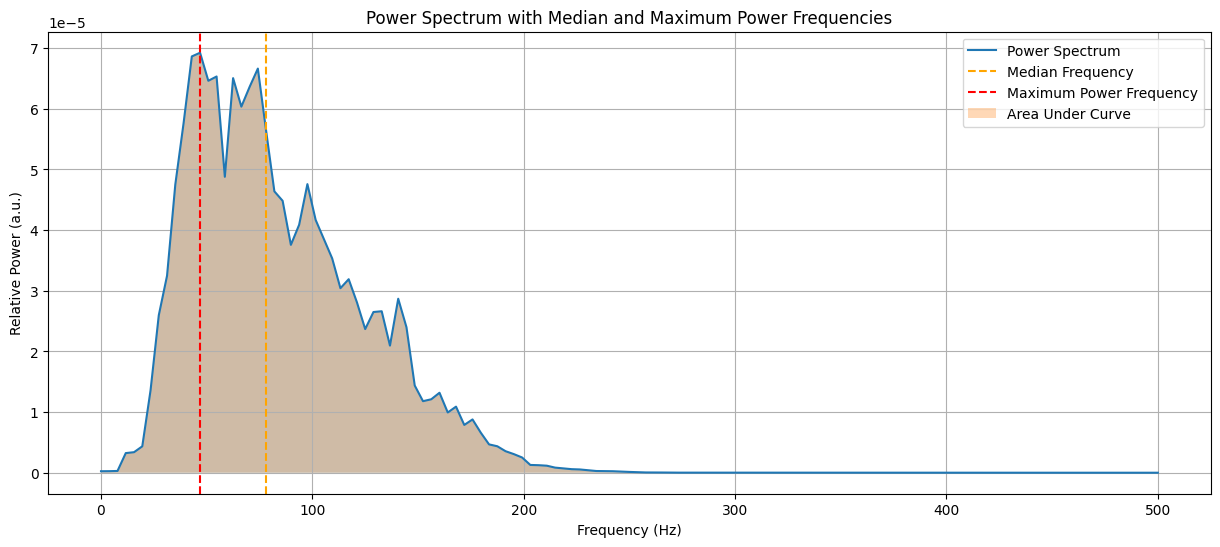

Total Power = 0.005970533337313641
[Median Frequency, Maximum Power Frequency] = [78.125, 46.875] Hz


In [59]:
plt.figure(figsize=(15, 6))

plt.plot(f, P, label='Power Spectrum')
plt.fill_between(f, P, alpha=0.3)

plt.axvline(median_freq, color='orange', linestyle='--', label='Median Frequency')
plt.axvline(f_max, color='red', linestyle='--', label='Maximum Power Frequency')
plt.fill_between(f, P, alpha=0.3, label='Area Under Curve')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative Power (a.u.)')
plt.title('Power Spectrum with Median and Maximum Power Frequencies')
plt.legend()
plt.grid()
plt.show()
# Imprimir los resultados
print(f"Total Power = {total_power}")
print(f"[Median Frequency, Maximum Power Frequency] = [{median_freq}, {f_max}] Hz")